In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import os

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Proj/dataset/Fake.csv")

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

Check number of articles in fake dataset

In [6]:
fake.shape[0] 

23481

In [7]:
real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Proj/dataset/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
real.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Check number of articles in real dataset

In [9]:
real['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [10]:
real.shape[0]

21417

In [11]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [12]:
# Hence we have a list of indices where publisher is not mentioned
real.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [13]:
# separating publishers from the news text
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        # add text to tmp_text and "unknown" to publishers
        #tmp_text.append(row)
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(' -', maxsplit=1)
    tmp_text.append(record[1])
    publisher.append(record[0])

In [14]:
#changing the dataframe by replacing text column by tmp_text and adding publisher column in df
real['publisher'] = publisher
real['text'] = tmp_text

In [15]:
del publisher, tmp_text, record, unknown_publishers

In [16]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [17]:
#checking for empty texts 

[index for index, text in enumerate(real.text.values) if str(text.strip()) == '']

[8970]

In [18]:
real.drop(8970, axis=0, inplace=True)

In [19]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [20]:
#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

In [21]:
# Adding class info
real['label'] = 1
fake['label'] = 0

In [22]:
real.head()

,title,text,subject,date,publisher,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


In [23]:
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [24]:
# combining title and text because in fake news some of the titles contains text also
real['text'] = real['text'] + " " + real['title']
fake['text'] = fake['text'] + " " + fake['title']

In [25]:
from textblob import TextBlob
real["polarity"] = real["text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
real["subjectivity"] = real["text"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
real["sentiment"] = np.select([real["polarity"] < 0, real["polarity"] == 0, real["polarity"] > 0],['neg', 'neu', 'pos'])

In [26]:
from textblob import TextBlob
fake["polarity"] = fake["text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
fake["subjectivity"] = fake["text"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
fake["sentiment"] = np.select([fake["polarity"] < 0, fake["polarity"] == 0, fake["polarity"] > 0],['neg', 'neu', 'pos'])

In [27]:
real.head()

,title,text,subject,date,publisher,label,polarity,subjectivity,sentiment
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.037083,0.410250,pos
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1,0.051296,0.292717,pos
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1,0.115930,0.316798,pos
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1,0.034969,0.298053,pos
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1,0.042165,0.396122,pos


In [28]:
fake.head()

,title,text,subject,date,label,polarity,subjectivity,sentiment
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,0.072534,0.600891,pos
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,-0.020811,0.344802,neg
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,-0.012345,0.541969,neg
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,-0.038021,0.413021,neg
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,-0.011722,0.495222,neg


In [29]:
# Subject is diffrent for real and fake thus dropping it
# Also dropping Date, title and Publication
real.drop(["subject", "date","title",  "publisher"], axis=1, inplace=True)
fake.drop(["subject", "date", "title"], axis=1, inplace=True)

In [30]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [31]:
data.head()

,text,label,polarity,subjectivity,sentiment
0,The head of a conservative Republican faction...,1,0.037083,0.410250,pos
1,Transgender people will be allowed for the fi...,1,0.051296,0.292717,pos
2,The special counsel investigation of links be...,1,0.115930,0.316798,pos
3,Trump campaign adviser George Papadopoulos to...,1,0.034969,0.298053,pos
4,President Donald Trump called on the U.S. Pos...,1,0.042165,0.396122,pos


In [32]:
# Download following if not downloaded

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
#Converting X to format acceptable by gensim, removing annd punctuation stopwords and setting case to lower
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del data

In [34]:
#!pip install gensim
import gensim

In [35]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors using Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [36]:
#sample vector for random word, lets say Zimbabwe 
w2v_model["zimbabwe"]

array([-0.29151744,  0.0056752 , -0.38856974,  0.50394374, -1.0586689 ,
       -0.21678178,  0.40169552, -0.9887434 , -0.03340635,  0.07847008,
        1.3570267 ,  0.5459762 , -2.3745134 , -0.41388443, -0.871496  ,
       -0.77216285,  1.380018  ,  0.24404971,  0.01181441, -0.7855225 ,
        1.6213604 , -0.46105793,  0.4228071 ,  0.72553533,  0.38310164,
        0.74616617, -0.5608006 ,  0.5589578 , -1.3852156 , -1.8118623 ,
       -0.7512103 ,  0.3438339 ,  0.38186902,  0.79671794,  1.5400442 ,
        0.8628969 ,  0.1526851 ,  0.03029923, -0.44615993, -1.0631722 ,
        0.01193711, -0.329499  ,  1.0797099 , -3.504177  , -0.75826335,
        1.2520351 ,  0.40232217, -0.0039479 , -0.91913325,  2.1248486 ,
        0.52502674,  0.43165576,  1.1295555 ,  0.13794866, -0.19815214,
        0.14557813, -0.45259678, -1.0215645 ,  1.6765159 ,  0.8317394 ,
        0.880864  ,  0.3797318 , -0.64183927, -0.051567  , -0.39527467,
        0.18867911, -0.25175184, -0.27756944, -0.17161615,  2.31

In [37]:
#similar words for 'Zimbabwe'
w2v_model.wv.most_similar('zimbabwe')

[('mugabe', 0.6296404600143433),
 ('mnangagwa', 0.6176605820655823),
 ('emmerson', 0.5060045123100281),
 ('junta', 0.49690884351730347),
 ('castro', 0.4930450916290283),
 ('dictatorship', 0.48367059230804443),
 ('chiwenga', 0.48109757900238037),
 ('khama', 0.45374196767807007),
 ('geun', 0.45288795232772827),
 ('vps', 0.4522135555744171)]

In [38]:
w2v_model.wv.most_similar('mandela')

[('9newseducation', 0.7279367446899414),
 ('nelson', 0.6845331788063049),
 ('bqzgj4ff6f', 0.6667296290397644),
 ('2017prince', 0.6566874980926514),
 ('gkcfxidtvz', 0.6416285634040833),
 ('truman', 0.6346117854118347),
 ('retiring', 0.6310865879058838),
 ('chamisa', 0.6304087042808533),
 ('margaret', 0.6298497915267944),
 ('eleanor', 0.6275911331176758)]

In [39]:
w2v_model.wv.most_similar('violence')

[('violent', 0.6849657297134399),
 ('riots', 0.6388846635818481),
 ('unrest', 0.6375746130943298),
 ('bloodshed', 0.6345760226249695),
 ('killings', 0.6198465824127197),
 ('flayed', 0.5926211476325989),
 ('clashes', 0.5837121605873108),
 ('rioting', 0.5803251266479492),
 ('acts', 0.5701963901519775),
 ('atrocities', 0.5696237087249756)]

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [41]:
#Checking word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break   

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


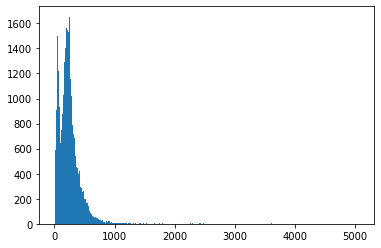

In [42]:
# Determining size of input...

# Number of words in news shows that most news articles are under 700 words.
# Keeping each news small and truncating all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed even though there are news with 5000 words.


In [43]:
# Out of 48k news, 44k have less than 700 words
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43982

In [44]:
# I made all news to 700, adding padding to short ones and truncting long ones
maxlen = 700
X = pad_sequences(X, maxlen = maxlen)

In [45]:
X

array([[    0,     0,     0, ...,  5509,  1286,  4840],
       [    0,     0,     0, ...,  9968,   127,  1386],
       [    0,     0,     0, ...,   411,  1168,   341],
       ...,
       [ 2209,   917,   268, ..., 26087,   928,   170],
       [    0,     0,     0, ...,  1085,   484, 10928],
       [    0,     0,     0, ...,  7096,    49,  7220]], dtype=int32)

In [46]:
# Adding 1 because of reserved 0 index.
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# The vocab size inceeases by 1

vocab_size = len(tokenizer.word_index) + 1

In [47]:
vocab_size

122249

In [48]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocab size + 0 for unknown words
    vocab_size = len(vocab)+1
    #initialize weight matrix with all zeros
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [49]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [50]:
# creating layers for neural network model
model = Sequential()
#adding a non-trainable embedding layer as input layer
model.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12224900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [52]:
y = data['label']

In [53]:
X.shape

(44897, 700)

In [54]:
y.shape

(44897,)

In [55]:
y = np.array(y)

In [56]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [58]:
X_train.shape

(35917, 700)

In [59]:
X_test.shape

(8980, 700)

In [60]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
786/786 [==============================] - 102s 122ms/step - loss: 0.0874 - acc: 0.9692 - val_loss: 0.0502 - val_acc: 0.9834
Epoch 2/6
786/786 [==============================] - 96s 122ms/step - loss: 0.0340 - acc: 0.9888 - val_loss: 0.0459 - val_acc: 0.9856
Epoch 3/6
786/786 [==============================] - 95s 121ms/step - loss: 0.0203 - acc: 0.9930 - val_loss: 0.0365 - val_acc: 0.9884
Epoch 4/6
786/786 [==============================] - 95s 120ms/step - loss: 0.0101 - acc: 0.9972 - val_loss: 0.0421 - val_acc: 0.9862
Epoch 5/6
786/786 [==============================] - 94s 119ms/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.0573 - val_acc: 0.9860
Epoch 6/6
786/786 [==============================] - 94s 119ms/step - loss: 0.0078 - acc: 0.9977 - val_loss: 0.0416 - val_acc: 0.9882


In [61]:
#Prediction is in probability of news being real, so converting into classes
# Label 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [62]:
accuracy_score(y_test, y_pred)

0.9878619153674832

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4644
           1       0.99      0.99      0.99      4336

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [64]:
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone Proj/models/lstmFake_v1.h5')
print('model saved!')

model saved!


In [66]:
import pickle 
with open('/content/drive/MyDrive/Colab Notebooks/Capstone Proj/models/tokenizer.tk', 'wb') as tokenizer_file:
  pickle.dump(tokenizer, tokenizer_file)
print('encoder saved!')

encoder saved!
